In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os
import re

import statsmodels.api as sm
import statsmodels.formula.api as smf
sm.OLS.from_formula
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [2]:
df_dow = pd.read_csv('./datasets/indicator_5_years.csv', sep=',')
df_dow.head(10)

,Date,Close/Last,Volume,Open,High,Low
0,05/10/2024,395.18,3505595,395.25,395.8989,394.0958
1,05/09/2024,394.00,4141242,390.11,394.2600,390.0100
2,05/08/2024,390.48,2855082,388.34,390.9100,388.1900
3,05/07/2024,388.74,2428600,389.17,389.7500,388.3400
4,05/06/2024,388.45,2596106,388.32,388.7400,386.8300
5,05/03/2024,386.77,4471092,387.14,387.9900,385.0600
6,05/02/2024,382.23,3535552,381.15,382.9100,378.9000
7,05/01/2024,378.89,5731591,378.38,383.4800,377.9800
8,04/30/2024,378.13,3463622,382.46,382.7490,378.0800
9,04/29/2024,383.80,3265901,383.10,384.0300,382.0700


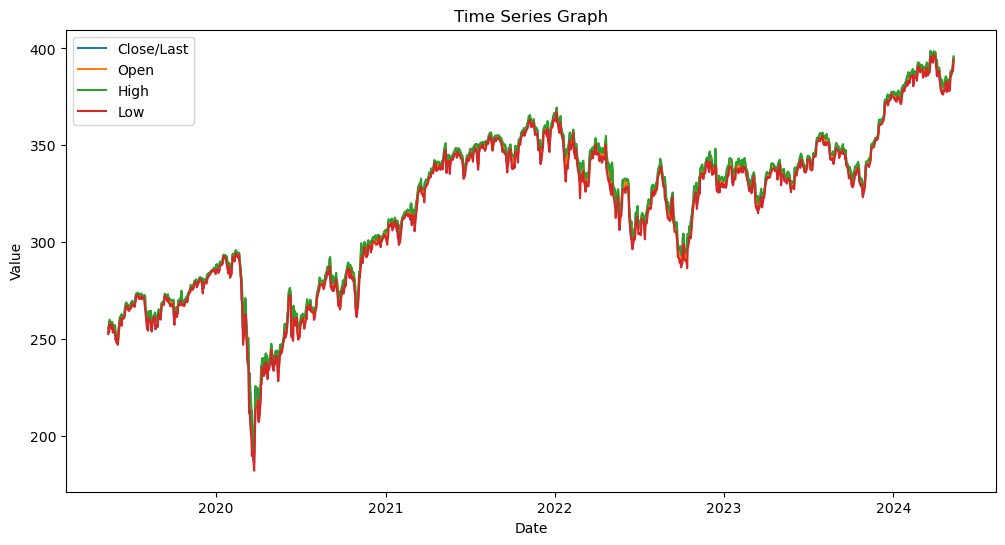

In [3]:
# Plot ilustrativo sobre los valores 'Close/Last', 'Open', 'High' and 'Low'. 

# Sorto las fechas
df_dow = df_dow.sort_values(by = "Date")
df_dow['Date'] = pd.to_datetime(df_dow['Date'])

# Convertir 'Date' a dummy de tiempo
df_dow['Time_index'] = pd.Series(np.arange(len(df_dow['Date'])), index=df_dow.index) 

plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Close/Last', data=df_dow, label='Close/Last')
sns.lineplot(x='Date', y='Open', data=df_dow, label='Open')
sns.lineplot(x='Date', y='High', data=df_dow, label='High')
sns.lineplot(x='Date', y='Low', data=df_dow, label='Low')


plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Graph')
plt.legend(loc='upper left')

plt.show()


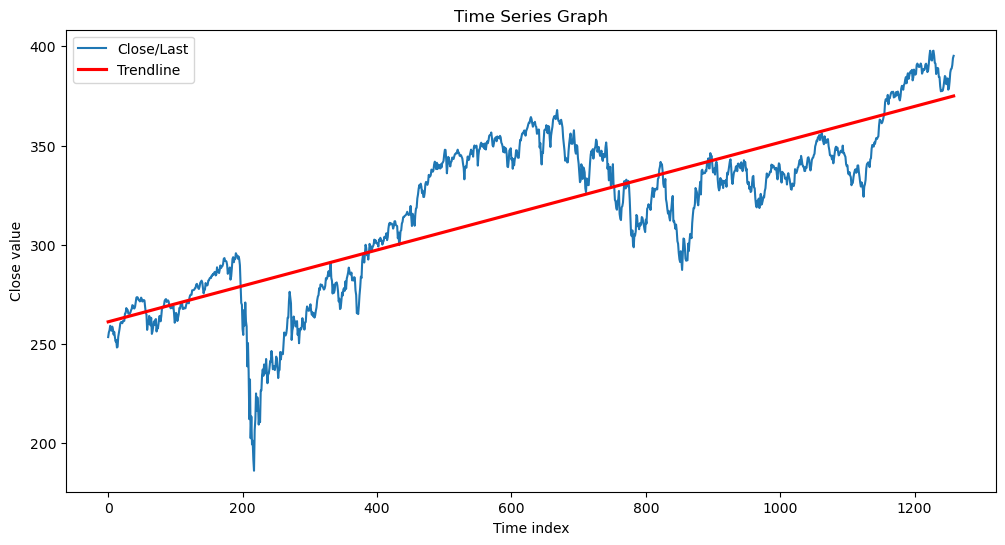

In [4]:
# Plot del valor 'Close/Last' y linea de regresion

# Sorto las fechas
df_dow = df_dow.sort_values(by = "Date")
df_dow['Date'] = pd.to_datetime(df_dow['Date'])

# Convertir 'Date' a dummy de tiempo
df_dow['Time_index'] = pd.Series(np.arange(len(df_dow['Date'])), index=df_dow.index) 

plt.figure(figsize=(12, 6))
sns.lineplot(x='Time_index', y='Close/Last', data=df_dow, label='Close/Last')
sns.regplot(x='Time_index', y='Close/Last', data=df_dow, scatter=False, label='Trendline', ci=None, color='red')


plt.xlabel('Time index')
plt.ylabel('Close value')
plt.title('Time Series Graph')
plt.legend(loc='upper left')

plt.show()

In [5]:
#defino lso nobmres de los csv a utilizar
company_dates = {
"Procter":("2019-05-13", "2024-05-10"),
"3M": ("2019-05-13", "2024-05-10"),
"Merck": ("2019-05-13", "2024-05-10"),
"IBM": ("2019-05-13", "2024-05-10"),
"Amex": ("2019-05-13", "2024-05-10"),
"McDonalds": ("2019-05-13","2024-05-10"),
"Coca": ("2019-05-13", "2024-05-10"),
"Boeing": ("2019-05-13","2024-05-10"),
"JPMorgan": ("2019-05-13", "2024-05-10"),
"Dow": ("2019-05-13","2024-05-10"),
"Disney": ("2019-05-13", "2024-05-10"),
"Caterpillar": ("2019-05-13", "2024-05-10"),
"Walmart": ("2019-05-13","2024-05-10"),
"JNJ": ("2019-05-13", "2024-05-10"),
"Microsoft": ("2019-05-13","2024-05-10"),
"Intel": ("2019-05-13", "2024-05-10"),
"HomeDepot": ("2019-05-13","2024-05-10"),
"Verizon": ("2019-05-13", "2024-05-10"),
"Chevron": ("2019-05-13","2024-05-10"),
"Travelers": ("2019-05-13", "2024-05-10"),
"Cisco": ("2019-05-13","2024-05-10"),
"UnitedHealth": ("2019-05-13", "2024-05-10"),
"Visa": ("2019-05-13","2024-05-10"),
"Nike": ("2019-05-13", "2024-05-10"),
"Apple": ("2019-05-13", "2024-05-10"),
"Goldman": ("2019-04-02","2024-05-10"),
"Salesforce": ("2020-08-31","2024-05-10"),
"Honeywell": ("2020-08-31","2024-05-10"),
"Amgen": ("2020-08-31","2024-05-10"),
"Amazon": ("2024-02-26","2024-05-10"),
"Exxon":("2019-05-13", "2020-08-30"),
"Pfizer": ("2019-05-13","2020-08-30"),
"Raytheon":("2019-05-13", "2020-08-30"),
"Walgreens":("2018-06-26", "2024-02-25"),
}


In [6]:
#filtro por fecha
def filter_company_data(company_df, start_date, end_date):
    return company_df[(company_df['Date'] >= start_date) & (company_df['Date'] <= end_date)]

In [7]:
# Creo nuevo df para mergear 
df_merge = df_dow.copy()

In [8]:
# Funcion para convertir signo dolar a numerico
def convert_dollars_to_numerical(value):
    if isinstance(value, str) and re.match(r'\$\d+', value):
        return float(value.replace('$', ''))
    return value


In [9]:
for company, (start_date, end_date) in company_dates.items():
    # cargo dataset de la compañia
    company_df = pd.read_csv(f'./datasets/companies/{company}.csv')
    company_df = company_df.applymap(convert_dollars_to_numerical)
    # Convierto a fecha  la columna date
    company_df['Date'] = pd.to_datetime(company_df['Date'])
    
    # obtengo 
    if company in company_dates:
        start_date, end_date = company_dates[company]
        
        # Filtro por fechas
        filtered_company_df = filter_company_data(company_df, start_date, end_date)
        
        # Mergeo con mi dataset 
        df_merge = pd.merge(df_merge, filtered_company_df, on='Date', how='left', suffixes=('', f'_{company}'))

# Save the merged dataset
df_merge.to_csv('./datasets/merged_dow_jones.csv', index=False)

In [10]:
pd.set_option('display.max_columns', None) 
df_merge.head()

,Date,Close/Last,Volume,Open,High,Low,Time_index,Close/Last_Procter,Volume_Procter,Open_Procter,High_Procter,Low_Procter,Close/Last_3M,Volume_3M,Open_3M,High_3M,Low_3M,Close/Last_Merck,Volume_Merck,Open_Merck,High_Merck,Low_Merck,Close/Last_IBM,Volume_IBM,Open_IBM,High_IBM,Low_IBM,Close/Last_Amex,Volume_Amex,Open_Amex,High_Amex,Low_Amex,Close/Last_McDonalds,Volume_McDonalds,Open_McDonalds,High_McDonalds,Low_McDonalds,Close/Last_Coca,Volume_Coca,Open_Coca,High_Coca,Low_Coca,Close/Last_Boeing,Volume_Boeing,Open_Boeing,High_Boeing,Low_Boeing,Close/Last_JPMorgan,Volume_JPMorgan,Open_JPMorgan,High_JPMorgan,Low_JPMorgan,Close/Last_Dow,Volume_Dow,Open_Dow,High_Dow,Low_Dow,Close/Last_Disney,Volume_Disney,Open_Disney,High_Disney,Low_Disney,Close/Last_Caterpillar,Volume_Caterpillar,Open_Caterpillar,High_Caterpillar,Low_Caterpillar,Close/Last_Walmart,Volume_Walmart,Open_Walmart,High_Walmart,Low_Walmart,Close/Last_JNJ,Volume_JNJ,Open_JNJ,High_JNJ,Low_JNJ,Close/Last_Microsoft,Volume_Microsoft,Open_Microsoft,High_Microsoft,Low_Microsoft,Close/Last_Intel,Volume_Intel,Open_Intel,High_Intel,Low_Intel,Close/Last_HomeDepot,Volume_HomeDepot,Open_HomeDepot,High_HomeDepot,Low_HomeDepot,Close/Last_Verizon,Volume_Verizon,Open_Verizon,High_Verizon,Low_Verizon,Close/Last_Chevron,Volume_Chevron,Open_Chevron,High_Chevron,Low_Chevron,Close/Last_Travelers,Volume_Travelers,Open_Travelers,High_Travelers,Low_Travelers,Close/Last_Cisco,Volume_Cisco,Open_Cisco,High_Cisco,Low_Cisco,Close/Last_UnitedHealth,Volume_UnitedHealth,Open_UnitedHealth,High_UnitedHealth,Low_UnitedHealth,Close/Last_Visa,Volume_Visa,Open_Visa,High_Visa,Low_Visa,Close/Last_Nike,Volume_Nike,Open_Nike,High_Nike,Low_Nike,Close/Last_Apple,Volume_Apple,Open_Apple,High_Apple,Low_Apple,Close/Last_Goldman,Volume_Goldman,Open_Goldman,High_Goldman,Low_Goldman,Close/Last_Salesforce,Volume_Salesforce,Open_Salesforce,High_Salesforce,Low_Salesforce,Close/Last_Honeywell,Volume_Honeywell,Open_Honeywell,High_Honeywell,Low_Honeywell,Close/Last_Amgen,Volume_Amgen,Open_Amgen,High_Amgen,Low_Amgen,Close/Last_Amazon,Volume_Amazon,Open_Amazon,High_Amazon,Low_Amazon,Close/Last_Exxon,Volume_Exxon,Open_Exxon,High_Exxon,Low_Exxon,Close/Last_Pfizer,Volume_Pfizer,Open_Pfizer,High_Pfizer,Low_Pfizer,Close/Last_Raytheon,Volume_Raytheon,Open_Raytheon,High_Raytheon,Low_Raytheon,Close/Last_Walgreens,Volume_Walgreens,Open_Walgreens,High_Walgreens,Low_Walgreens
0,2019-05-13,253.47,6326032,254.67,255.7000,252.59,0,106.11,7575536,105.14,106.590,104.850,149.4209,5916911,149.3050,149.8587,148.3221,74.4746,9200151,74.1368,74.8220,74.1368,127.2023,4958021,129.0026,129.2833,126.7571,115.90,3710632,116.42,116.890,115.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,131.34,11389900,131.50,132.66,130.55,125.30,8580682,127.51,127.520,124.080,33.2967,22084637,33.4833,33.7167,33.0033,137.20,5560421,137.85,138.0600,136.5302,123.35,33944920,124.110,125.55,123.04,44.76,39091930,45.33,45.640,44.7000,190.34,3326028,191.00,191.660,189.14,56.75,13759350,56.72,57.34,56.66,120.44,7701636,121.91,122.26,120.0100,143.41,1611771,142.38,143.7900,141.95,51.30,28869930,51.83,52.26,51.06,239.55,4684437,236.45,240.100,236.1974,157.33,9729964,157.19,158.7200,156.4200,82.53,6445267,81.65,82.630,81.32,46.430,229722480,46.9275,47.3700,45.7125,194.97,3605565,197.90,197.90,194.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.71,12176300.0,75.65,76.23,75.36,39.6560,26575850.0,39.3237,39.7342,39.2455,78.2462,4119212.0,79.4737,79.8532,77.3153,52.12,5670544.0,52.94,53.0900,51.96
1,2019-05-14,255.81,4308796,254.40,257.2300,254.24,1,105.60,7004005,105.77,106.500,105.570,150.3995,4013992,150.0389,151.9102,149.7986,74.7159,7742178,74.9089,75.3528,74.6580,129.0317,3280374,127.5895,130.0093,127.4540,117.01,2460661,115.98,117.730,115.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.20,12001740,133.52,134.66,132.05,127.47,401907

In [11]:
# Filtro los datos para crear un nuevo dataframe con los valores de "Date" y "Close/Last"

df_columns = df_merge.columns.values.tolist()

regex = 'Close'
date = 'Date'
list_close_last = [ x for x in df_columns if re.search(regex, x) or re.search(date, x)]

print(list_close_last)

df_close_last = df_merge[list_close_last]


['Date', 'Close/Last', 'Close/Last_Procter', 'Close/Last_3M', 'Close/Last_Merck', 'Close/Last_IBM', 'Close/Last_Amex', 'Close/Last_McDonalds', 'Close/Last_Coca', 'Close/Last_Boeing', 'Close/Last_JPMorgan', 'Close/Last_Dow', 'Close/Last_Disney', 'Close/Last_Caterpillar', 'Close/Last_Walmart', 'Close/Last_JNJ', 'Close/Last_Microsoft', 'Close/Last_Intel', 'Close/Last_HomeDepot', 'Close/Last_Verizon', 'Close/Last_Chevron', 'Close/Last_Travelers', 'Close/Last_Cisco', 'Close/Last_UnitedHealth', 'Close/Last_Visa', 'Close/Last_Nike', 'Close/Last_Apple', 'Close/Last_Goldman', 'Close/Last_Salesforce', 'Close/Last_Honeywell', 'Close/Last_Amgen', 'Close/Last_Amazon', 'Close/Last_Exxon', 'Close/Last_Pfizer', 'Close/Last_Raytheon', 'Close/Last_Walgreens']


In [12]:
# Renombrar columnas para mayor claridad
rename_function = lambda name: 'Index' if name == 'Close/Last' else name.split('_')[-1]

# Funcion para renombrar
new_column_names = list(map(rename_function, list_close_last))

df_close_last.rename(columns=dict(zip(df_close_last.columns, new_column_names)), inplace=True)

df_close_last.head()

C:\Users\juan\AppData\Local\Temp\ipykernel_13300\4002656954.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_close_last.rename(columns=dict(zip(df_close_last.columns, new_column_names)), inplace=True)


,Date,Index,Procter,3M,Merck,IBM,Amex,McDonalds,Coca,Boeing,JPMorgan,Dow,Disney,Caterpillar,Walmart,JNJ,Microsoft,Intel,HomeDepot,Verizon,Chevron,Travelers,Cisco,UnitedHealth,Visa,Nike,Apple,Goldman,Salesforce,Honeywell,Amgen,Amazon,Exxon,Pfizer,Raytheon,Walgreens
0,2019-05-13,253.47,106.11,149.4209,74.4746,127.2023,115.90,NaN,NaN,NaN,NaN,NaN,131.34,125.30,33.2967,137.20,123.35,44.76,190.34,56.75,120.44,143.41,51.30,239.55,157.33,82.53,46.430,194.97,NaN,NaN,NaN,NaN,75.71,39.6560,78.2462,52.12
1,2019-05-14,255.81,105.60,150.3995,74.7159,129.0317,117.01,NaN,NaN,NaN,NaN,NaN,133.20,127.47,33.4300,136.82,124.73,45.17,191.62,56.55,121.64,145.71,52.02,236.43,160.21,83.67,47.165,196.28,NaN,NaN,NaN,NaN,75.81,39.7440,79.4440,52.58
2,2019-05-15,256.92,106.70,149.4638,74.8413,130.0867,117.66,NaN,NaN,NaN,NaN,NaN,134.68,127.30,33.2933,136.91,126.02,45.62,191.76,56.81,122.14,146.52,52.44,236.08,162.79,84.01,47.730,196.40,NaN,NaN,NaN,NaN,76.37,40.2229,79.4440,52.74
3,2019-05-16,259.16,108.11,147.4809,76.3661,131.5192,119.84,199.99,49.58,353.81,111.31,52.98,135.50,126.61,33.7700,138.21,128.93,45.53,192.38,57.38,120.80,147.41,55.93,236.79,164.87,84.28,47.520,199.14,NaN,NaN,NaN,NaN,76.36,40.7019,80.1971,52.50
4,2019-05-17,257.44,107.45,145.1461,75.9705,130.0093,119.07,199.22,49.20,355.02,110.77,50.80,135.04,122.76,33.6200,138.61,128.07,44.89,192.58,58.09,120.52,147.49,56.35,241.38,164.09,84.57,47.250,197.43,NaN,NaN,NaN,NaN,75.91,40.5357,79.3076,52.27


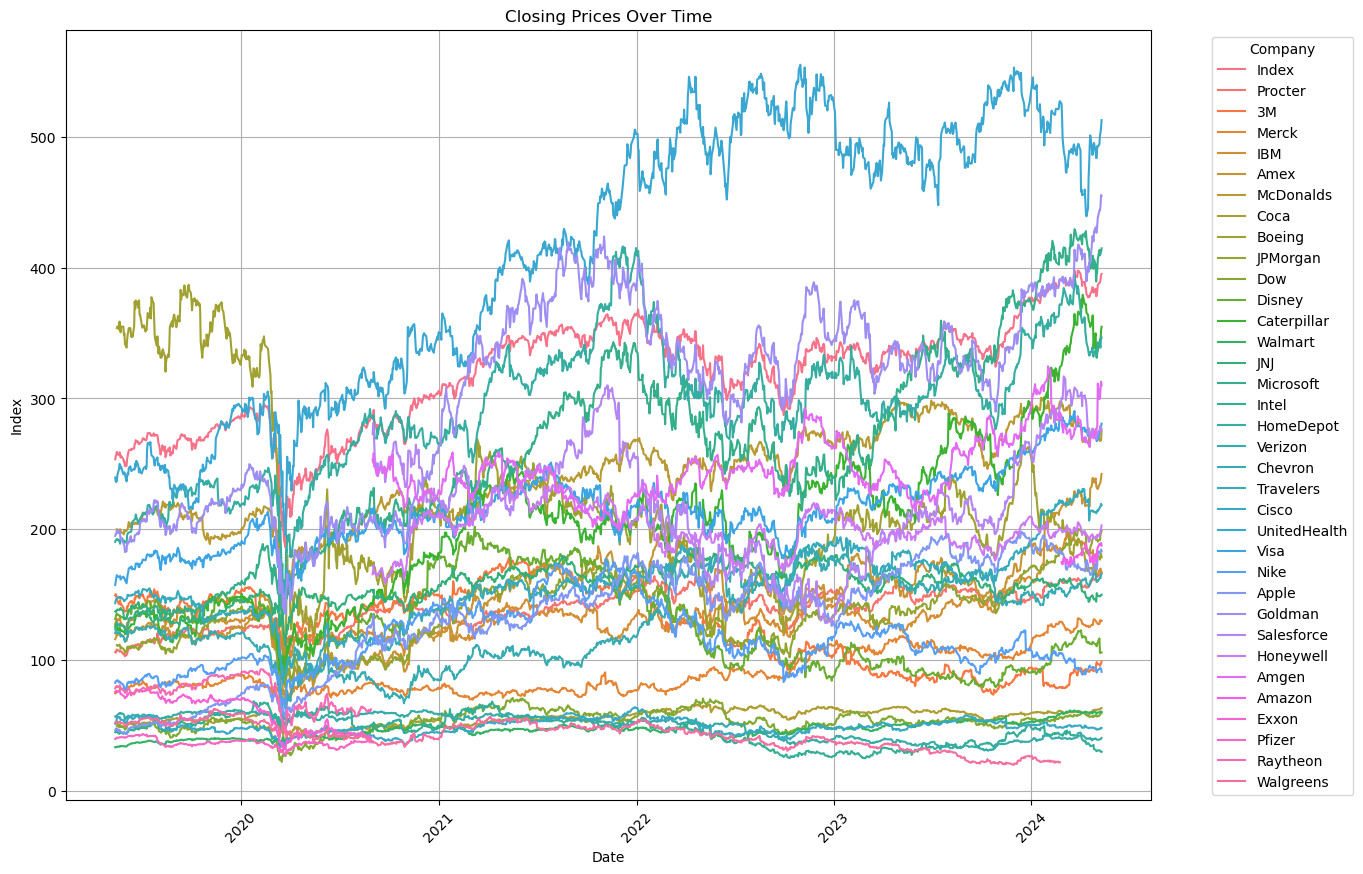

In [13]:
# Plot de los valores para cada empresa

melted_df = df_close_last.melt(id_vars=['Date'], var_name='Company', value_name='Close_value')

plt.figure(figsize=(14, 10))
sns.lineplot(data=melted_df, x='Date', y='Close_value', hue='Company')

plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Index')
plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [14]:
# Correlaciones:

# Matriz de correlacion
correlation_matrix = df_close_last.corr()
print(correlation_matrix)


                  Date     Index   Procter        3M     Merck       IBM  \
Date          1.000000  0.812762  0.822364 -0.750303  0.812223  0.578149   
Index         0.812762  1.000000  0.859556 -0.291794  0.577563  0.652232   
Procter       0.822364  0.859556  1.000000 -0.420867  0.587033  0.477098   
3M           -0.750303 -0.291794 -0.420867  1.000000 -0.839521 -0.426505   
Merck         0.812223  0.577563  0.587033 -0.839521  1.000000  0.700250   
IBM           0.578149  0.652232  0.477098 -0.426505  0.700250  1.000000   
Amex          0.767736  0.925216  0.769889 -0.352470  0.618962  0.714243   
McDonalds     0.904501  0.847611  0.831443 -0.630658  0.787962  0.597174   
Coca          0.693199  0.694803  0.735629 -0.457999  0.624176  0.496240   
Boeing       -0.506327 -0.217270 -0.438399  0.339455 -0.173217  0.098658   
JPMorgan      0.597153  0.889657  0.633673 -0.125154  0.473040  0.691686   
Dow           0.326181  0.709756  0.531877  0.241455  0.091838  0.309836   
Disney      

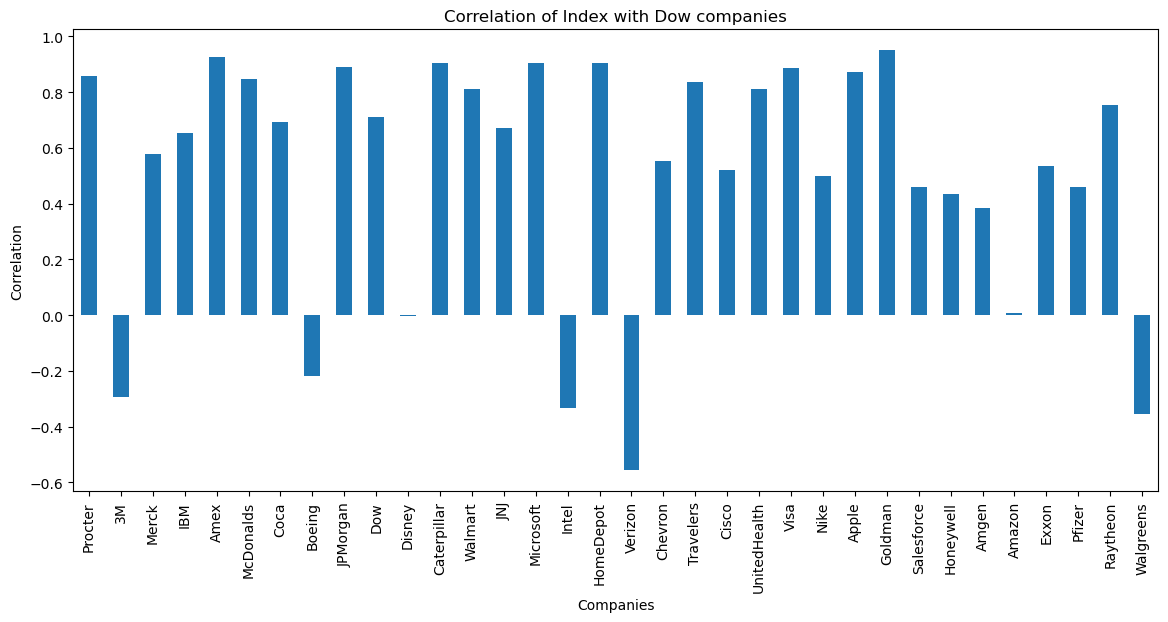

In [15]:
# Correlacion de las empresas con el Dow Index
# Son demasiadas empresas, por lo tanto las correlaciones se muestran mejor como grafico de histogramas
# Transposicion de la matriz
correlation_matrix = correlation_matrix[['Index']].transpose()

# Todas las correlaciones a partir de la segunda columna
correlations = correlation_matrix.loc['Index', 'Procter':]

# Plot 
plt.figure(figsize=(14, 6))
correlations.plot(kind='bar')
plt.xlabel('Companies')
plt.ylabel('Correlation')
plt.title('Correlation of Index with Dow companies')
plt.xticks(rotation=90, fontsize=10)
plt.show()

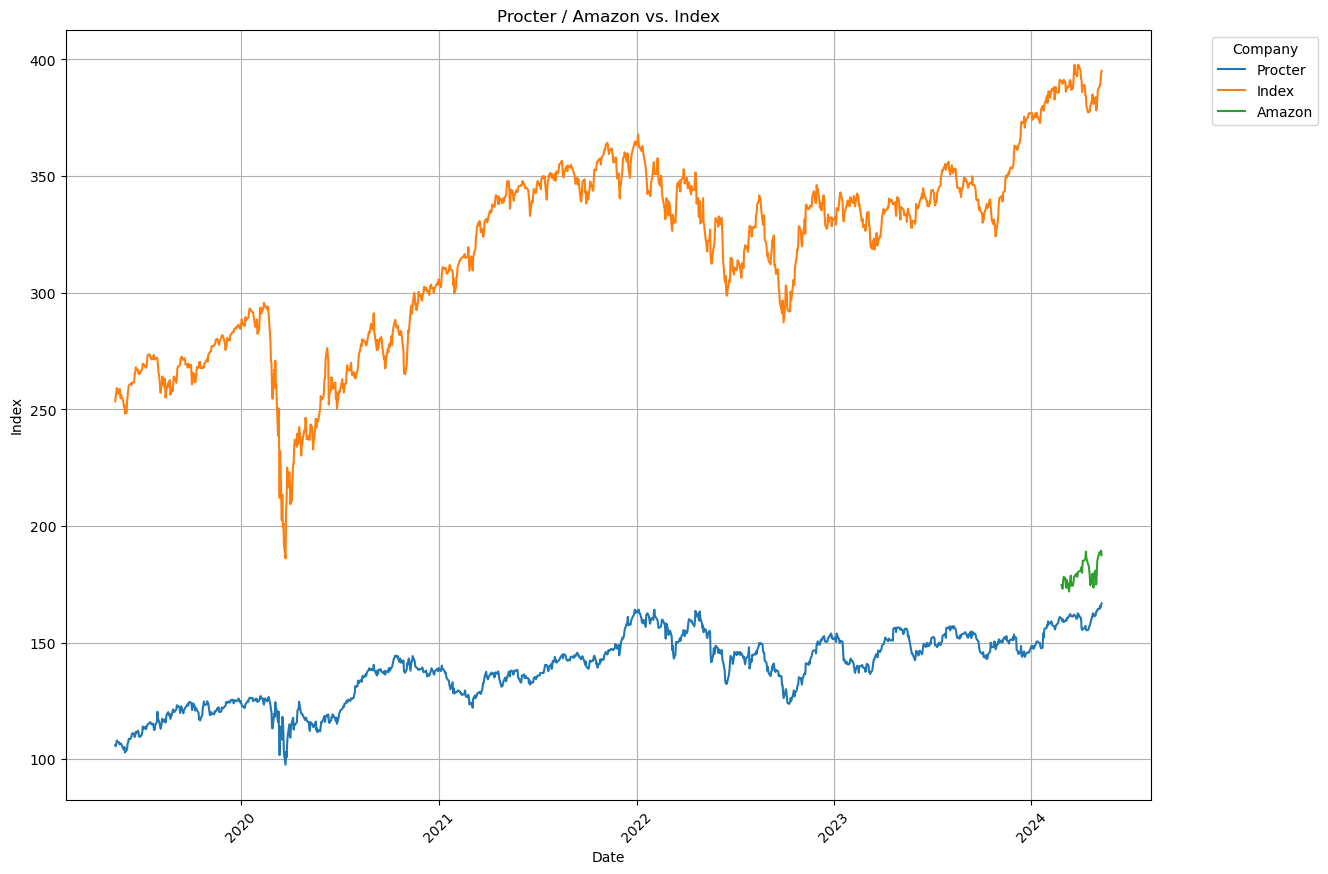

In [16]:
# Porque la correlacion de Amazon es tan baja respecto al Index? 
# Porque se sumó hace muy poco tiempo. 
# Ver la comparacion con Procter (la mas antigua)

plt.figure(figsize=(14, 10))
sns.lineplot(x='Date', y='Procter', data=df_close_last, label='Procter')
sns.lineplot(x='Date', y='Index', data=df_close_last, label='Index')
sns.lineplot(x='Date', y='Amazon', data=df_close_last, label='Amazon')

plt.title('Procter / Amazon vs. Index')
plt.xlabel('Date')
plt.ylabel('Index')
plt.legend(title='Company', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [17]:
df_close_last.head(2)

,Date,Index,Procter,3M,Merck,IBM,Amex,McDonalds,Coca,Boeing,JPMorgan,Dow,Disney,Caterpillar,Walmart,JNJ,Microsoft,Intel,HomeDepot,Verizon,Chevron,Travelers,Cisco,UnitedHealth,Visa,Nike,Apple,Goldman,Salesforce,Honeywell,Amgen,Amazon,Exxon,Pfizer,Raytheon,Walgreens
0,2019-05-13,253.47,106.11,149.4209,74.4746,127.2023,115.90,NaN,NaN,NaN,NaN,NaN,131.34,125.30,33.2967,137.20,123.35,44.76,190.34,56.75,120.44,143.41,51.30,239.55,157.33,82.53,46.430,194.97,NaN,NaN,NaN,NaN,75.71,39.656,78.2462,52.12
1,2019-05-14,255.81,105.60,150.3995,74.7159,129.0317,117.01,NaN,NaN,NaN,NaN,NaN,133.20,127.47,33.4300,136.82,124.73,45.17,191.62,56.55,121.64,145.71,52.02,236.43,160.21,83.67,47.165,196.28,NaN,NaN,NaN,NaN,75.81,39.744,79.4440,52.58


In [18]:
df_close_last.dtypes

Date            datetime64[ns]
Index                  float64
Procter                float64
3M                     float64
Merck                  float64
IBM                    float64
Amex                   float64
McDonalds              float64
Coca                   float64
Boeing                 float64
JPMorgan               float64
Dow                    float64
Disney                 float64
Caterpillar            float64
Walmart                float64
JNJ                    float64
Microsoft              float64
Intel                  float64
HomeDepot              float64
Verizon                float64
Chevron                float64
Travelers              float64
Cisco                  float64
UnitedHealth           float64
Visa                   float64
Nike                   float64
Apple                  float64
Goldman                float64
Salesforce             float64
Honeywell              float64
Amgen                  float64
Amazon                 float64
Exxon   

In [19]:
df_close_last.isna().sum()

Date               0
Index              0
Procter            0
3M                 0
Merck              0
IBM                0
Amex               0
McDonalds          3
Coca               3
Boeing             3
JPMorgan           3
Dow                3
Disney             0
Caterpillar        0
Walmart            0
JNJ                0
Microsoft          0
Intel              0
HomeDepot          0
Verizon            0
Chevron            0
Travelers          0
Cisco              0
UnitedHealth       0
Visa               0
Nike               0
Apple              0
Goldman            0
Salesforce       329
Honeywell        329
Amgen            329
Amazon          1205
Exxon            930
Pfizer           930
Raytheon         930
Walgreens         54
dtype: int64

In [20]:
df_close_last.shape

(1259, 36)

In [21]:
print(df_close_last.columns)

Index(['Date', 'Index', 'Procter', '3M', 'Merck', 'IBM', 'Amex', 'McDonalds',
       'Coca', 'Boeing', 'JPMorgan', 'Dow', 'Disney', 'Caterpillar', 'Walmart',
       'JNJ', 'Microsoft', 'Intel', 'HomeDepot', 'Verizon', 'Chevron',
       'Travelers', 'Cisco', 'UnitedHealth', 'Visa', 'Nike', 'Apple',
       'Goldman', 'Salesforce', 'Honeywell', 'Amgen', 'Amazon', 'Exxon',
       'Pfizer', 'Raytheon', 'Walgreens'],
      dtype='object')


In [22]:
df_close_last.head(3)

,Date,Index,Procter,3M,Merck,IBM,Amex,McDonalds,Coca,Boeing,JPMorgan,Dow,Disney,Caterpillar,Walmart,JNJ,Microsoft,Intel,HomeDepot,Verizon,Chevron,Travelers,Cisco,UnitedHealth,Visa,Nike,Apple,Goldman,Salesforce,Honeywell,Amgen,Amazon,Exxon,Pfizer,Raytheon,Walgreens
0,2019-05-13,253.47,106.11,149.4209,74.4746,127.2023,115.90,NaN,NaN,NaN,NaN,NaN,131.34,125.30,33.2967,137.20,123.35,44.76,190.34,56.75,120.44,143.41,51.30,239.55,157.33,82.53,46.430,194.97,NaN,NaN,NaN,NaN,75.71,39.6560,78.2462,52.12
1,2019-05-14,255.81,105.60,150.3995,74.7159,129.0317,117.01,NaN,NaN,NaN,NaN,NaN,133.20,127.47,33.4300,136.82,124.73,45.17,191.62,56.55,121.64,145.71,52.02,236.43,160.21,83.67,47.165,196.28,NaN,NaN,NaN,NaN,75.81,39.7440,79.4440,52.58
2,2019-05-15,256.92,106.70,149.4638,74.8413,130.0867,117.66,NaN,NaN,NaN,NaN,NaN,134.68,127.30,33.2933,136.91,126.02,45.62,191.76,56.81,122.14,146.52,52.44,236.08,162.79,84.01,47.730,196.40,NaN,NaN,NaN,NaN,76.37,40.2229,79.4440,52.74


In [23]:
# Select relevant features
features = [col for col in df_close_last.columns if 'Date' not in col]
print(features)
# Extract the selected features
feature_data = df_close_last[features].fillna(df_close_last.mean())

# Normalize the data
scaler = StandardScaler()
scaled_feature_data = scaler.fit_transform(feature_data)

['Index', 'Procter', '3M', 'Merck', 'IBM', 'Amex', 'McDonalds', 'Coca', 'Boeing', 'JPMorgan', 'Dow', 'Disney', 'Caterpillar', 'Walmart', 'JNJ', 'Microsoft', 'Intel', 'HomeDepot', 'Verizon', 'Chevron', 'Travelers', 'Cisco', 'UnitedHealth', 'Visa', 'Nike', 'Apple', 'Goldman', 'Salesforce', 'Honeywell', 'Amgen', 'Amazon', 'Exxon', 'Pfizer', 'Raytheon', 'Walgreens']


In [24]:
# Apply PCA
pca = PCA(n_components=5)  # Choose the number of components based on your requirement
principal_components = pca.fit_transform(scaled_feature_data)

# Create a DataFrame for the principal components
pc_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])

df_close_last = pd.concat([df_close_last[[features[0]]],df_close_last[['Date']], pc_df], axis=1)
df_close_last.head()

,Index,Date,PC1,PC2,PC3,PC4,PC5
0,253.47,2019-05-13,5.293180,-0.055989,-3.729834,-0.789869,-0.171547
1,255.81,2019-05-14,5.187518,-0.204933,-3.869699,-0.749917,-0.193679
2,256.92,2019-05-15,5.113952,-0.309582,-4.003500,-0.759821,-0.297125
3,259.16,2019-05-16,5.779256,-0.715885,-4.686704,-0.331664,-0.501772
4,257.44,2019-05-17,5.894486,-0.577306,-4.540939,-0.310013,-0.472178


In [25]:
# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print('Explained variance by component:', explained_variance)

Explained variance by component: [0.46156272 0.17361559 0.10518162 0.07118912 0.03188569]


In [26]:
# Correlaciones:

# Matriz de correlacion
correlation_matrix = df_close_last.corr()
print(correlation_matrix)


          Index      Date           PC1           PC2           PC3  \
Index  1.000000  0.812762 -9.401087e-01 -3.287094e-01  3.895180e-02   
Date   0.812762  1.000000 -9.486366e-01  2.620146e-01  1.163475e-01   
PC1   -0.940109 -0.948637  1.000000e+00 -1.301586e-16 -3.975675e-16   
PC2   -0.328709  0.262015 -1.301586e-16  1.000000e+00 -3.459778e-16   
PC3    0.038952  0.116347 -3.975675e-16 -3.459778e-16  1.000000e+00   
PC4    0.032798  0.005660  1.707951e-16  2.177904e-16 -9.084359e-18   
PC5   -0.000330 -0.016568 -3.721698e-17 -1.243446e-16 -1.996053e-16   

                PC4           PC5  
Index  3.279755e-02 -3.304437e-04  
Date   5.660344e-03 -1.656764e-02  
PC1    1.707951e-16 -3.721698e-17  
PC2    2.177904e-16 -1.243446e-16  
PC3   -9.084359e-18 -1.996053e-16  
PC4    1.000000e+00 -3.215254e-16  
PC5   -3.215254e-16  1.000000e+00  


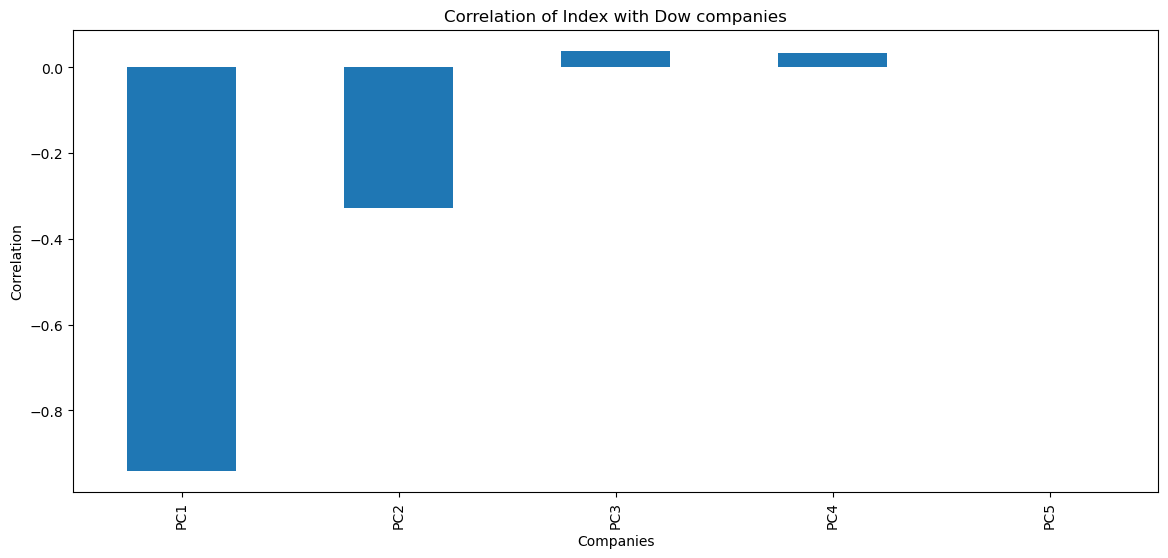

In [27]:
# Correlacion de las empresas con el Dow Index
# Son demasiadas empresas, por lo tanto las correlaciones se muestran mejor como grafico de histogramas
# Transposicion de la matriz
correlation_matrix = correlation_matrix[['Index']].transpose()

# Todas las correlaciones a partir de la segunda columna
correlations = correlation_matrix.loc['Index', 'PC1':]

# Plot 
plt.figure(figsize=(14, 6))
correlations.plot(kind='bar')
plt.xlabel('Companies')
plt.ylabel('Correlation')
plt.title('Correlation of Index with Dow companies')
plt.xticks(rotation=90, fontsize=10)
plt.show()

In [28]:
#cambio el nombre al df y me quedo son con la columna de las fechas y el valor de dowjones con el nombre Price
df_tryout = df_close_last[['Date', 'Index']].copy()
df_tryout.rename(columns={'Index': 'Price'}, inplace=True)
df_tryout.head(2)

,Date,Price
0,2019-05-13,253.47
1,2019-05-14,255.81


<Figure size 1600x1000 with 0 Axes>

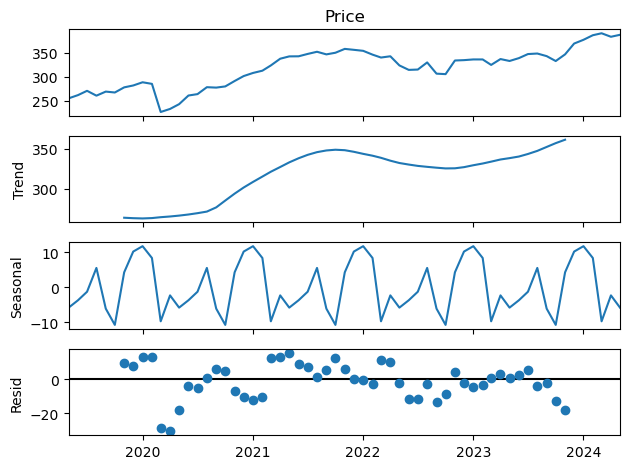

In [29]:
#descompongo en la sesionalidad
df_tryout = df_tryout.set_index('Date')
y = df_tryout['Price'].resample('MS').mean()

import statsmodels.api as sm
plt.figure(figsize=(16,10))
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot()
plt.show()

In [30]:
#formula para el RMSE
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

In [31]:
# predicción con random walk, creo que no tiene sentido ni hacerlo ni mostrarlo

In [32]:
from sklearn.model_selection import train_test_split

df_try_train, df_try_test = train_test_split(df_tryout, test_size=300, random_state=2024, shuffle=False)

In [33]:
df_try_train.tail(3)

,Price
Date,
2023-02-28,326.57
2023-03-01,327.00
2023-03-02,330.44


In [34]:
df_try_test.head(3)

,Price
Date,
2023-03-03,334.21
2023-03-06,334.68
2023-03-07,328.87


In [35]:
#genero desplazo en train
df_try_train["PriceShift1"] = df_try_train.Price.shift()

# La primera observación nos va a quedar en nan, la reemplazamos por el valor siguente:
df_try_train["PriceShift1"].fillna(method='bfill', inplace=True)
df_try_train.head(3)

,Price,PriceShift1
Date,,
2019-05-13,253.47,253.47
2019-05-14,255.81,253.47
2019-05-15,256.92,255.81


In [36]:
#genero desplazo en test
df_try_test["PriceShift1"] = df_try_test.Price.shift()

df_try_test["PriceShift1"].fillna(method='bfill', inplace=True)
df_try_test.head(3)

,Price,PriceShift1
Date,,
2023-03-03,334.21,334.21
2023-03-06,334.68,334.21
2023-03-07,328.87,334.68


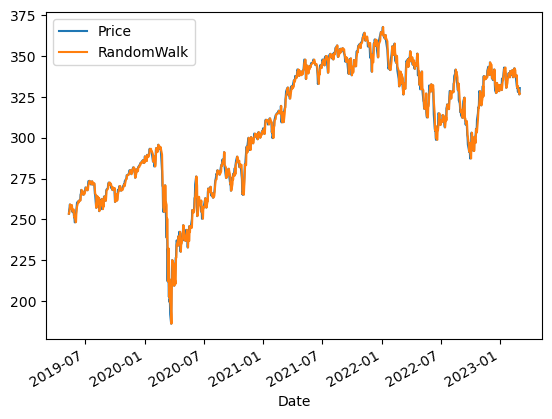

In [37]:
df_try_train["RandomWalk"] = df_try_train.PriceShift1
df_try_train.plot(kind="line", y = ["Price", "RandomWalk"]);

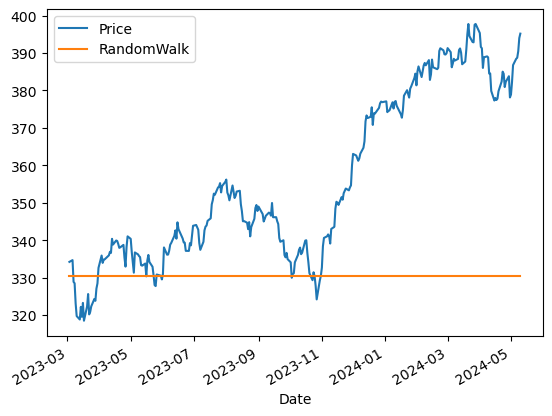

In [38]:
df_try_test["RandomWalk"] = pd.Series(df_try_train["Price"][-1], index=df_try_test.index)
df_try_test.plot(kind="line", y = ["Price", "RandomWalk"]);

In [39]:
#creo un df de resultados
df_Results = pd.DataFrame(columns = ["Model", "RMSE"])
df_Results.loc[0, "Model"] = "Random Walk"
df_Results.loc[0, "RMSE"] = RMSE(df_try_test.RandomWalk, df_try_test.Price)
df_Results

,Model,RMSE
0,Random Walk,33.582208


In [40]:
# prediccion con la media, no tiene sentido ni hacer ni mostrarlo para mi

In [41]:
# defino funcion predictiva con la media
def mean_pred(df, target_column, test_size):
    
    data = df.copy()
    
    #separa en train y test
    data_train, data_test = train_test_split(data, test_size=test_size, random_state=2024, shuffle=False)

    model_mean_pred = data_train[target_column].mean()
    print('Mean: ', model_mean_pred)
    
    #df_train_mc = data train.copy()
    data_train['Mean'] = model_mean_pred
    
    #df_test_mc = data_train.copy()
    data_test['Mean'] = model_mean_pred
    
    data_combined = pd.concat([data_train, data_test])
    fig, ax = plt.subplots(figsize=(10,5))
    data_combined.plot(kind='line', y=[target_column,"Mean"], ax=ax)
    ax.axvline(data_train.index[-1], color='r', linestyle='--', lw=2)  # línea para separar el entrenamiento y la prueba
    plt.title('Train and Test')
    plt.show()
    
    model_RMSE = RMSE(data_test.Mean, data_test[target_column])

    df_Results.loc[1, "Model"] = "Mean"
    df_Results.loc[1, "RMSE"] = model_RMSE
    print(df_Results.head())
    
    return

Mean:  306.39640250260686


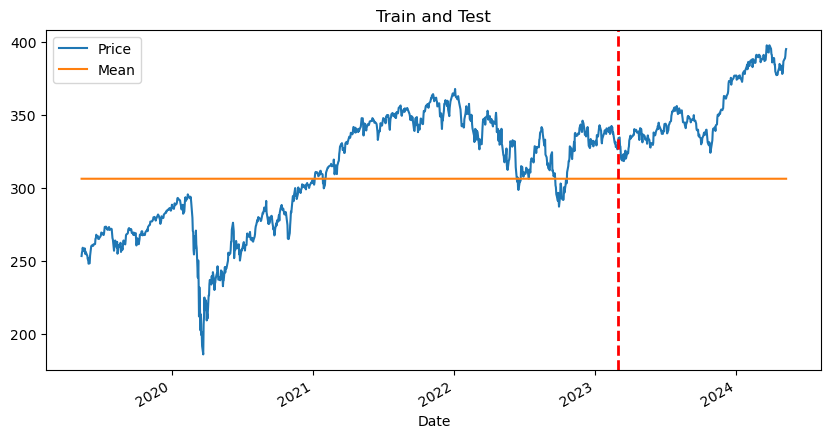

         Model       RMSE
0  Random Walk  33.582208
1         Mean  53.881827


In [42]:
mean_pred(df_tryout,'Price', 300)

In [43]:
# tendencia lineal

In [44]:
# defino una formula para predecir con la tendencia lineal
def lineal_pred(df, target_column,test_size):
    
    data = df.copy()
    
    data["timeIndex"] = pd.Series(np.arange(len(data[target_column])), index=data.index)
    data.timeIndex.head(3)
    
    data_train, data_test = train_test_split(data, test_size=test_size, random_state=2024, shuffle=False)
    
    formula = f'{target_column} ~ timeIndex'
    model_linear = smf.ols(formula=formula, data = data_train).fit()
    
    data_train["LinearTrend"] = model_linear.predict(data_train.timeIndex)
    data_test["LinearTrend"] = model_linear.predict(data_test.timeIndex)
    
    data_combined = pd.concat([data_train, data_test])
    fig, ax = plt.subplots(figsize=(10,5))
    data_combined.plot(kind='line', y=[target_column,"LinearTrend"], ax=ax)
    ax.axvline(data_train.index[-1], color='r', linestyle='--', lw=2)  # línea para separar el entrenamiento y la prueba
    plt.title('Train and Test')
    plt.show()
    
    model_RMSE = RMSE(data_test.LinearTrend, data_test[target_column])
    
    df_Results.loc[2, "Model"] = "LinearTrend"
    df_Results.loc[2, "RMSE"] = model_RMSE
    print(df_Results.head())
    print( )
    print(model_linear.summary())
    
    return

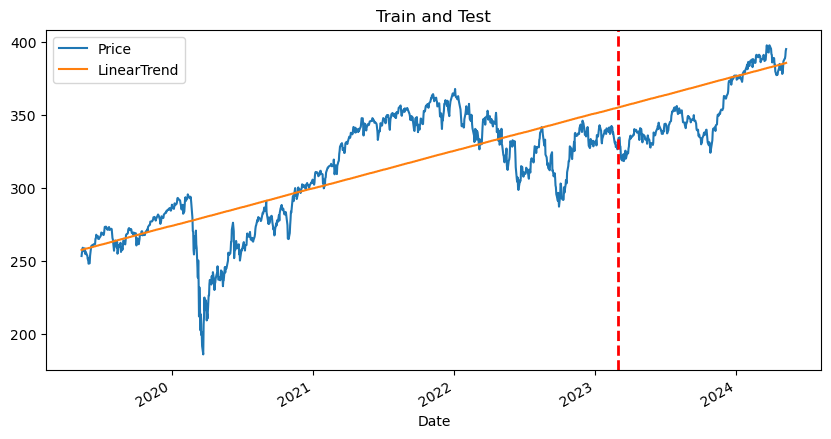

         Model       RMSE
0  Random Walk  33.582208
1         Mean  53.881827
2  LinearTrend  21.511379

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     1220.
Date:                Sun, 19 May 2024   Prob (F-statistic):          5.36e-173
Time:                        19:46:17   Log-Likelihood:                -4446.2
No. Observations:                 959   AIC:                             8896.
Df Residuals:                     957   BIC:                             8906.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [45]:
lineal_pred(df_tryout, 'Price', 300)

In [46]:
# predicción cuadratica

In [47]:
#defino una formula para predecicción exponencial
def exp_pred(df, target_column, test_size, exp):
   
    data = df.copy()
    
    data["timeIndex"] = pd.Series(np.arange(len(data[target_column])), index=data.index)
    data["timeIndex_exp"] = data["timeIndex"]**exp
    data.timeIndex_exp.head(3)
    
    data_train, data_test = train_test_split(data, test_size = test_size, random_state=2024, shuffle=False)
    
    formula = f'{target_column} ~ timeIndex + timeIndex_exp'
    model_exp = smf.ols(formula = formula, data = data_train).fit()

    data_train["ExpTrend"] = model_exp.predict(data_train[["timeIndex","timeIndex_exp"]])
    data_test["ExpTrend"] = model_exp.predict(data_test[["timeIndex","timeIndex_exp"]])
    
    data_combined = pd.concat([data_train, data_test])
    fig, ax = plt.subplots(figsize=(10,5))
    data_combined.plot(kind='line', y=[target_column,"ExpTrend"], ax=ax)
    ax.axvline(data_train.index[-1], color='r', linestyle='--', lw=2)  # línea para separar el entrenamiento y la prueba
    plt.title('Train and Test')
    plt.show()
    
    model_RMSE = RMSE(data_test.ExpTrend, data_test[target_column])
    
    df_Results.loc[3, "Model"] = "ExpTrend"
    df_Results.loc[3, "RMSE"] = model_RMSE
    print(df_Results.head())
    print( )
    print(model_exp.summary())
    
    return

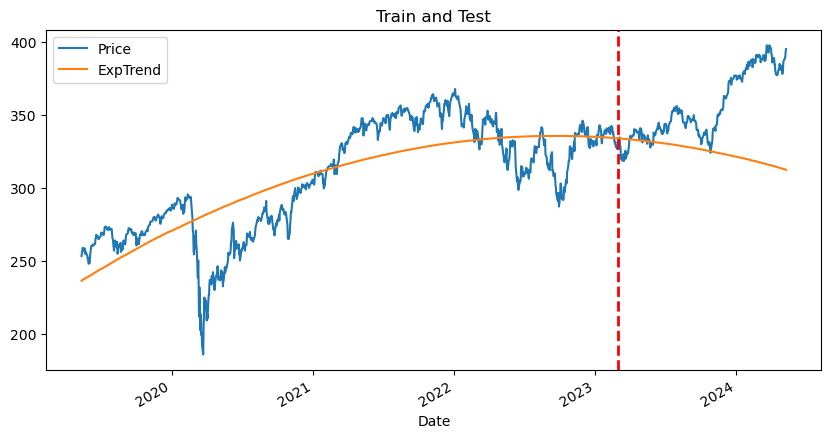

         Model       RMSE
0  Random Walk  33.582208
1         Mean  53.881827
2  LinearTrend  21.511379
3     ExpTrend  41.310631

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     792.1
Date:                Sun, 19 May 2024   Prob (F-statistic):          1.35e-203
Time:                        19:46:18   Log-Likelihood:                -4371.7
No. Observations:                 959   AIC:                             8749.
Df Residuals:                     956   BIC:                             8764.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.97

In [48]:
exp_pred(df_tryout, 'Price', 300, 2)

In [49]:
# tendencia logaritmica

In [50]:
# defino una función para hacer predección logaritmica
def log_pred(df, target_column, test_size):
    
    data = df.copy()
    
    data["timeIndex"] = pd.Series(np.arange(len(data[target_column])), index=data.index)

    data_train, data_test = train_test_split(data, test_size = test_size, random_state=2024, shuffle=False)
    
    data_train['log_target'] = np.log(data_train[target_column])
    data_test['log_target'] = np.log(data_test[target_column])
    
    model_log = smf.ols('log_target ~ timeIndex ', data = data_train).fit()
    
    data_train["LogTrend"] = model_log.predict(data_train[["timeIndex"]])
    data_test["LogTrend"] = model_log.predict(data_test[["timeIndex"]])
    
    data_train['back_LogTrend'] = np.exp(data_train['LogTrend'])
    data_test['back_LogTrend'] = np.exp(data_test['LogTrend'])
    
    data_combined = pd.concat([data_train, data_test])
    fig, ax = plt.subplots(figsize=(10,5))
    data_combined.plot(kind='line', y=[target_column,"back_LogTrend"], ax=ax)
    ax.axvline(data_train.index[-1], color='r', linestyle='--', lw=2)  # línea para separar el entrenamiento y la prueba
    plt.title('Train and Test')
    plt.show()
    
    model_RMSE = RMSE(data_test.back_LogTrend, data_test[target_column])
    
    df_Results.loc[4, "Model"] = "back_LogTrend"
    df_Results.loc[4, "RMSE"] = model_RMSE
    print(df_Results.head())
    print( )
    print(model_log.summary())
    
    return    

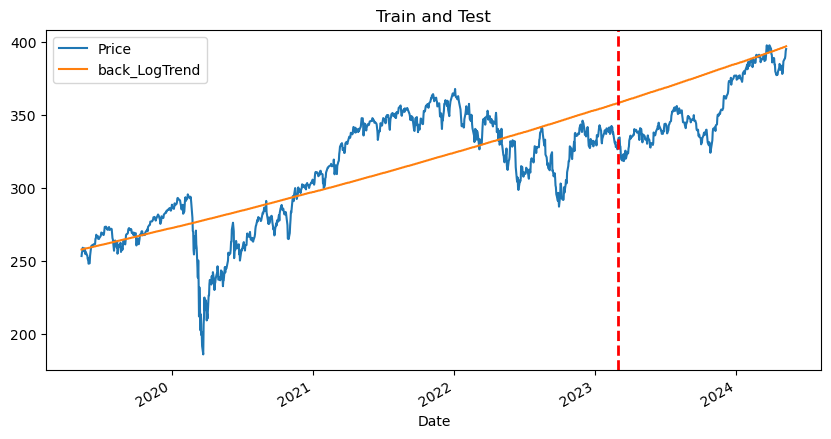

           Model       RMSE
0    Random Walk  33.582208
1           Mean  53.881827
2    LinearTrend  21.511379
3       ExpTrend  41.310631
4  back_LogTrend  25.922098

                            OLS Regression Results                            
Dep. Variable:             log_target   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     1185.
Date:                Sun, 19 May 2024   Prob (F-statistic):          1.28e-169
Time:                        19:46:18   Log-Likelihood:                 999.31
No. Observations:                 959   AIC:                            -1995.
Df Residuals:                     957   BIC:                            -1985.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err         

In [51]:
log_pred(df_tryout, 'Price', 300)

In [52]:
# media movil
df_tryout.head()

,Price
Date,
2019-05-13,253.47
2019-05-14,255.81
2019-05-15,256.92
2019-05-16,259.16
2019-05-17,257.44


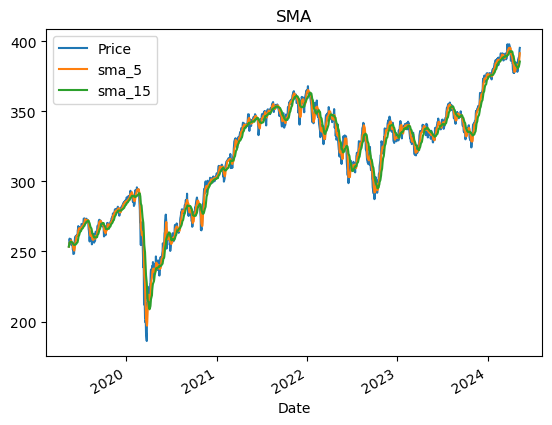

In [53]:
df_tryout_mm = df_tryout.copy()
df_tryout_mm["sma_5"] = df_tryout_mm.Price.rolling(5,min_periods=1).mean()
df_tryout_mm["sma_15"] = df_tryout_mm.Price.rolling(15,min_periods=1).mean()

df_tryout_mm.plot(kind = "line", y = ["Price","sma_5","sma_15"],title='SMA');

,Model,RMSE
0,Random Walk,33.582208
1,Mean,53.881827
2,LinearTrend,21.511379
3,ExpTrend,41.310631
4,back_LogTrend,25.922098
6,Simple Smoothing a=0.3,90.088566
7,Simple Smoothing a=0.5,90.819513
8,Simple Smoothing a=0.8,91.576684


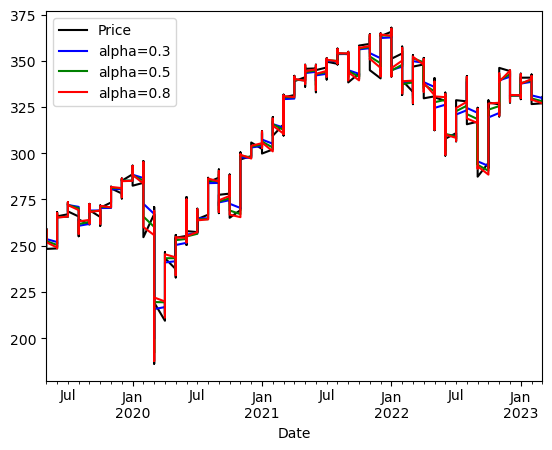

In [54]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

df_tryout5 = df_tryout.copy()

df_tryout5.index = pd.DatetimeIndex(df_tryout5.index).to_period('M')

df_train5, df_test5 = train_test_split(df_tryout5, test_size=300, random_state=2024, shuffle=False)

model_exp_smoothing_3 = SimpleExpSmoothing(df_train5.Price).fit(smoothing_level=0.3,optimized=False)
model_exp_smoothing_5 = SimpleExpSmoothing(df_train5.Price).fit(smoothing_level=0.5,optimized=False)
model_exp_smoothing_8 = SimpleExpSmoothing(df_train5.Price).fit(smoothing_level=0.8,optimized=False)

df_train5.plot(kind = "line", y = "Price",color='black')
model_exp_smoothing_3.fittedvalues.plot(label="alpha=0.3",color='b');
model_exp_smoothing_5.fittedvalues.plot(label="alpha=0.5",color='g');
model_exp_smoothing_8.fittedvalues.plot(label="alpha=0.8",color='r');
plt.legend();

df_test5["Simple_Smoothing_3"] = model_exp_smoothing_3.forecast(len(df_test5))
df_test5["Simple_Smoothing_5"] = model_exp_smoothing_5.forecast(len(df_test5))
df_test5["Simple_Smoothing_8"] = model_exp_smoothing_8.forecast(len(df_test5))

model5_RMSE_3 = RMSE(df_test5["Simple_Smoothing_3"], df_test5.Price)
model5_RMSE_5 = RMSE(df_test5["Simple_Smoothing_5"], df_test5.Price)
model5_RMSE_8 = RMSE(df_test5["Simple_Smoothing_8"], df_test5.Price)

df_Results.loc[6, "Model"] = "Simple Smoothing a=0.3"; df_Results.loc[6, "RMSE"] = model5_RMSE_3
df_Results.loc[7, "Model"] = "Simple Smoothing a=0.5"; df_Results.loc[7, "RMSE"] = model5_RMSE_5
df_Results.loc[8, "Model"] = "Simple Smoothing a=0.8"; df_Results.loc[8, "RMSE"] = model5_RMSE_8
df_Results

In [55]:
# Revisar!!!

In [56]:
df_tryout1 = df_tryout.copy()
df_tryout1["timeIndex"] = pd.Series(np.arange(len(df_tryout1['Price'])), index=df_tryout1.index)
df_tryout1['log_value'] = np.log(df_tryout1['Price'])

df_tryout1['month'] = [d.strftime('%b') for d in df_tryout1.index]
dummies_mes = pd.get_dummies(df_tryout1['month'])
df_tryout1 = df_tryout1.join(dummies_mes)

In [57]:
df_train1, df_test1 = train_test_split(df_tryout1, test_size=300, random_state=2024, shuffle=False)
model_log_est = smf.ols( \
    'log_value ~ timeIndex',\
    data = df_train1).fit()

In [58]:
df_train1['model_log_est'] = model_log_est.predict(
    df_train1[["timeIndex"]])
df_test1['model_log_est'] = model_log_est.predict(  
    df_test1[["timeIndex"]])

In [59]:
df_train1['back_model_log_est'] = np.exp(df_train1['model_log_est'])
df_test1['back_model_log_est'] = np.exp(df_test1['model_log_est'])

In [60]:
df_Results2 = pd.DataFrame(columns = ["Model", "RMSE"])
df_Results2.loc[0, "Model"] = "Log Model + est"
df_Results2.loc[0, "RMSE"] = RMSE(df_test1['back_model_log_est'], df_test1['Price'])
df_Results2

,Model,RMSE
0,Log Model + est,25.922098


In [61]:
# Test de Dickey-Fuller

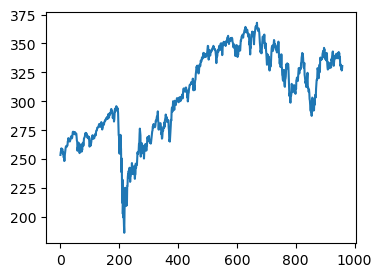

In [62]:
plt.figure(figsize=(4,3)); plt.plot(df_train1.timeIndex, df_train1.Price); plt.show()

In [63]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_train1['Price']); 
print('ADF Statistic: %f' % result[0]); print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -1.849356
p-value: 0.356247
Valor crítico 1%: -3.44
Valor crítico 5%: -2.86
Valor crítico 10%: -2.57


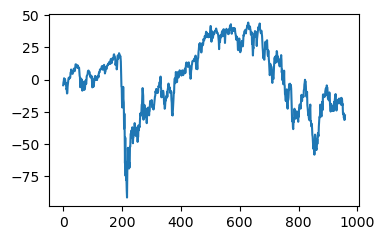

In [64]:
res_model = df_train1['Price'] - df_train1['back_model_log_est']
plt.figure(figsize=(4,2.5)); plt.plot(df_train1.timeIndex, res_model, '-');plt.show()

In [65]:
result = adfuller(res_model); print('ADF Statistic: %f' % result[0]); 
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -2.291334
p-value: 0.174778
Valor crítico 1%: -3.44
Valor crítico 5%: -2.86
Valor crítico 10%: -2.57


# Modelo ARIMA, hay que revisar

In [66]:
df_arima = df_close_last[['Date', 'Index']].copy()
df_arima.rename(columns={'Index': 'Price'}, inplace=True)
df_arima.head(2)

,Date,Price
0,2019-05-13,253.47
1,2019-05-14,255.81


<Figure size 1600x1000 with 0 Axes>

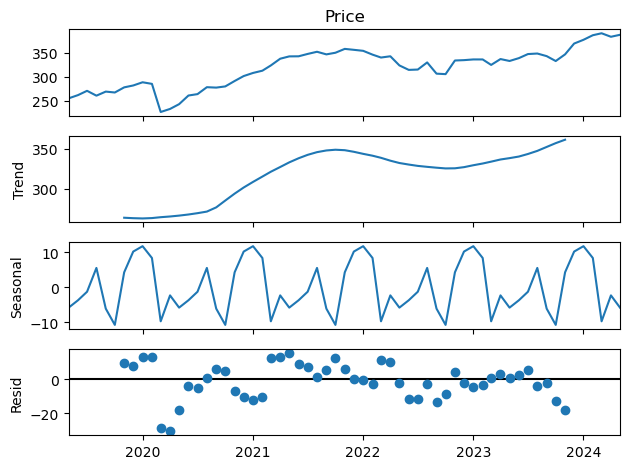

In [67]:
#descompongo en la sesionalidad
df_arima = df_arima.set_index('Date')
y = df_arima['Price'].resample('MS').mean()

import statsmodels.api as sm
plt.figure(figsize=(16,10))
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot()
plt.show()

<Axes: xlabel='Date'>

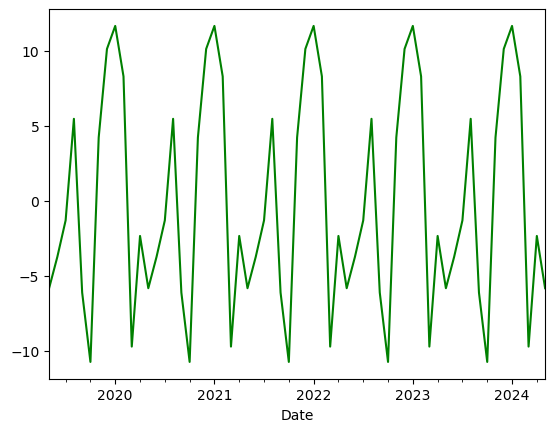

In [68]:
seasonality=decomposition.seasonal
seasonality.plot(color='green')

In [69]:
from statsmodels.tsa.stattools import adfuller
df_arima_test = adfuller(df_arima.Price, autolag = 'AIC')
print("1. ADF : ",df_arima_test[0])
print("2. P-Value : ", df_arima_test[1])
print("3. Num Of Lags : ", df_arima_test[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", df_arima_test[3])
print("5. Critical Values :")
for key, val in df_arima_test[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.4151247520694963
2. P-Value :  0.5750040285538082
3. Num Of Lags :  9
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1249
5. Critical Values :
	 1% :  -3.4355964295197743
	 5% :  -2.863856825923603
	 10% :  -2.5680035060041626


In [70]:
# el p valua es alto, vamos por el rolling

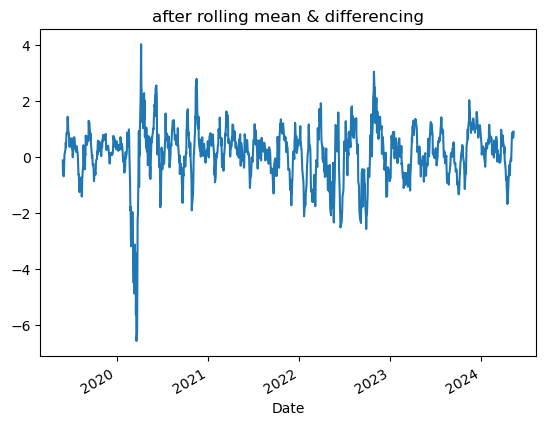

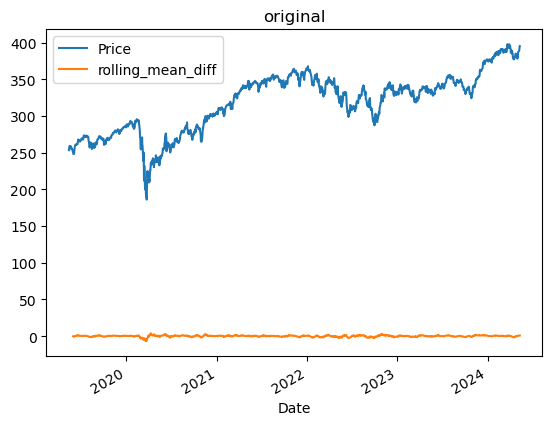

In [71]:
rolling_mean = df_arima.rolling(window = 12).mean()
df_arima['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()
ax1 = plt.subplot()
df_arima['rolling_mean_diff'].plot(title='after rolling mean & differencing');
ax2 = plt.subplot()
df_arima.plot(title='original');

In [72]:
df_arima_test = adfuller(df_arima['rolling_mean_diff'].dropna(), autolag = 'AIC')
print("1. ADF : ",df_arima_test[0])
print("2. P-Value : ", df_arima_test[1])
print("3. Num Of Lags : ", df_arima_test[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", df_arima_test[3])
print("5. Critical Values :")
for key, val in df_arima_test[4].items():
  print("\t",key, ": ", val)

1. ADF :  -8.614704644416
2. P-Value :  6.336442762068664e-14
3. Num Of Lags :  21
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1225
5. Critical Values :
	 1% :  -3.435699433298302
	 5% :  -2.863902271843875
	 10% :  -2.5680277086214076


In [73]:
#ahora que el p valur es bajo aplicamos arima

In [74]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.api as smt

In [75]:
df_arima_train, df_arima_test = train_test_split(df_arima, test_size=300, random_state=2024, shuffle=False)

In [76]:
model_ARIMA = ARIMA(df_arima['Price'],order=(1,1,1))
results_ARIMA = model_ARIMA.fit()
results_ARIMA.summary()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                 1259
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3376.263
Date:                Sun, 19 May 2024   AIC                           6758.525
Time:                        19:46:19   BIC                           6773.937
Sample:                             0   HQIC                          6764.317
                               - 1259                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4662      0.077     -6.064      0.000      -0.617      -0.316
ma.L1          0.3449      0.083      4.176      0.000       0.183       0.507
sigma2        12.5506      0.240     52.244      0.000      12.080      13.021
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):              3486.21
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                            -0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
df_arima_train.shape

(959, 2)

In [78]:
predictions_ARIMA = results_ARIMA.forecast(len(df_arima_test['Price']))

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [79]:
df_arima_train['model_ARIMA'] = df_arima_train['Price'] + results_ARIMA.fittedvalues
df_arima_test['model_ARIMA'] = df_arima_test['Price'] + predictions_ARIMA

In [80]:
#model_ARIMA = ARIMA(df_arima['Price'], order=(2,0,2))
#results_ARIMA = model_ARIMA.fit()

In [81]:
print(results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 1259
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3376.263
Date:                Sun, 19 May 2024   AIC                           6758.525
Time:                        19:46:19   BIC                           6773.937
Sample:                             0   HQIC                          6764.317
                               - 1259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4662      0.077     -6.064      0.000      -0.617      -0.316
ma.L1          0.3449      0.083      4.176      0.000       0.183       0.507
sigma2        12.5506      0.240     52.244      0.0

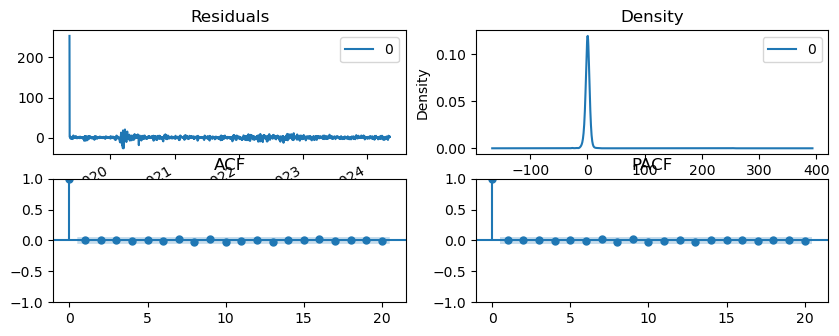

In [82]:
residuals = pd.DataFrame(results_ARIMA.resid)
fig, axes = plt.subplots(2, 2,figsize=(10,4))

residuals.plot(title="Residuals", ax=axes[0,0]); 
residuals.plot(kind='kde', title='Density', ax=axes[0,1])
smt.graphics.plot_acf(residuals, lags=20,ax=axes[1,0],title='ACF'); 
smt.graphics.plot_pacf(residuals, lags=20,ax=axes[1,1],title='PACF')
plt.show()

In [83]:
predictions_ARIMA = results_ARIMA.forecast(len(df_arima_test['Price']), alpha=0.05)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [84]:
df_arima_train['model_ARIMA'] = df_arima_train['Price'] + results_ARIMA.fittedvalues
df_arima_test['model_ARIMA'] = df_arima_test['Price'] + predictions_ARIMA

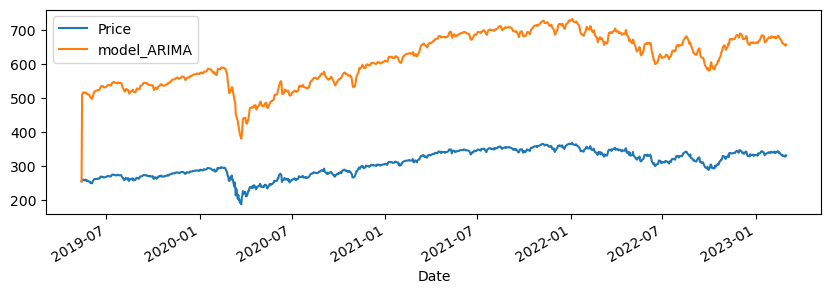

In [85]:
df_arima_train.plot(kind = "line", y = ['Price', 'model_ARIMA'],figsize=(10,3));

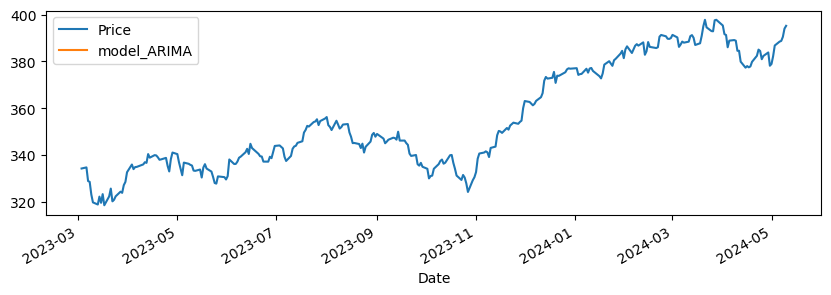

In [86]:
df_arima_test.plot(kind = "line", y = ['Price', 'model_ARIMA'],figsize=(10,3));

In [87]:
df_arima_test.tail(5)

,Price,rolling_mean_diff,model_ARIMA
Date,,,
2024-05-06,388.45,0.884167,NaN
2024-05-07,388.74,0.745000,NaN
2024-05-08,390.48,0.675833,NaN
2024-05-09,394.00,0.748333,NaN
2024-05-10,395.18,0.895000,NaN


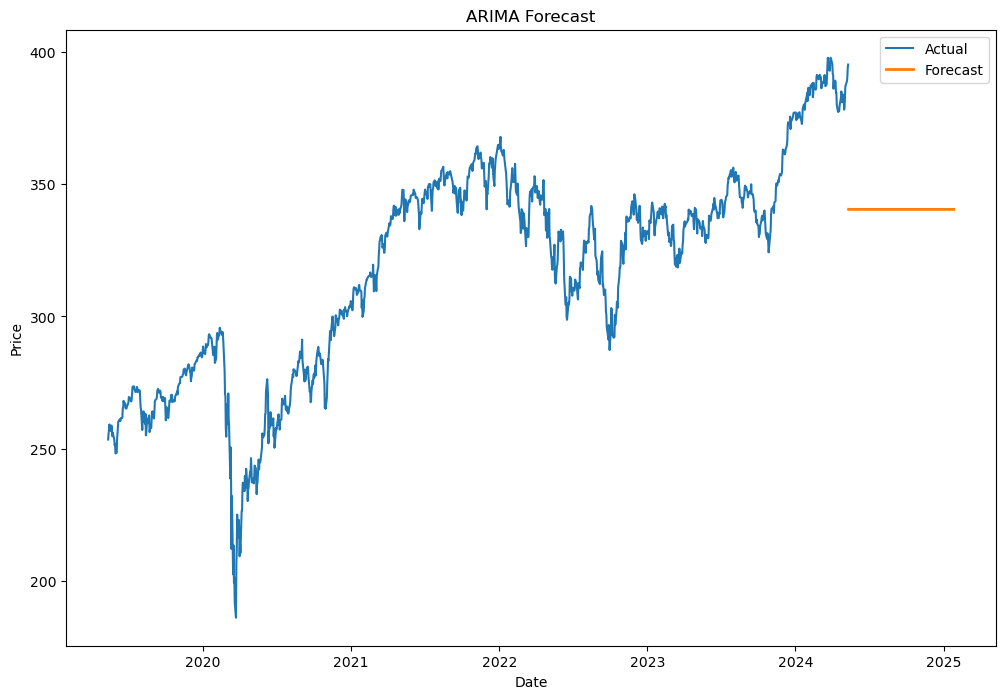

In [88]:
from statsmodels.tsa.arima.model import ARIMA

df_arima3 = df_close_last.copy()
df_arima3.rename(columns={'Index': 'Price'}, inplace=True)
# Ajustar el modelo ARIMA
model = ARIMA(df_arima3['Price'], order=(1, 1, 1))
model_fit = model.fit()

# Generar pronósticos para los próximos 30 pasos de tiempo
start_index = 1000
end_index = 1259
#forecast = model_fit.forecast(steps=30)
forecast=model_fit.predict(start=1000,end=1259,dynamic=True)

# Agregar los pronósticos al DataFrame original
dates = pd.date_range(start=df_arima3['Date'].iloc[-1], periods=261, freq='D')[1:]
forecast_df = pd.DataFrame({'Date': dates, 'forecast': forecast})
df_arima3 = pd.concat([df_arima3, forecast_df])

# Graficar los datos originales y los pronósticos
plt.figure(figsize=(12, 8))
plt.plot(df_arima3['Date'], df_arima3['Price'], label='Actual')
plt.plot(df_arima3['Date'], df_arima3['forecast'], label='Forecast', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

# Arima 2

In [89]:
df_arima2 = df_close_last[['Date', 'Index']].copy()
df_arima2.rename(columns={'Index': 'Price'}, inplace=True)
df_arima2.head(2)

,Date,Price
0,2019-05-13,253.47
1,2019-05-14,255.81


In [90]:
df_arima2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1259 non-null   datetime64[ns]
 1   Price   1259 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.8 KB


In [91]:
df_arima2 = df_arima2.set_index('Date')
df_arima2.head(2)

,Price
Date,
2019-05-13,253.47
2019-05-14,255.81


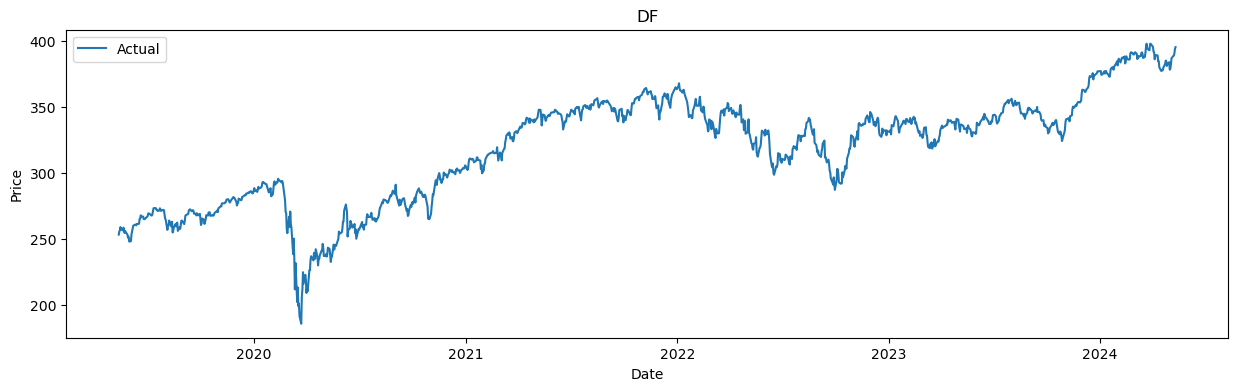

In [92]:
plt.figure(figsize=(15, 4))
plt.plot(df_arima2.index, df_arima2['Price'], label='Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('DF')
plt.legend()
plt.show()

In [93]:
df_arima2.describe()

,Price
count,1259.000000
mean,318.058999
std,40.456763
min,186.130000
25%,283.125000
50%,330.260000
75%,345.930000
max,397.760000


<Axes: ylabel='Density'>

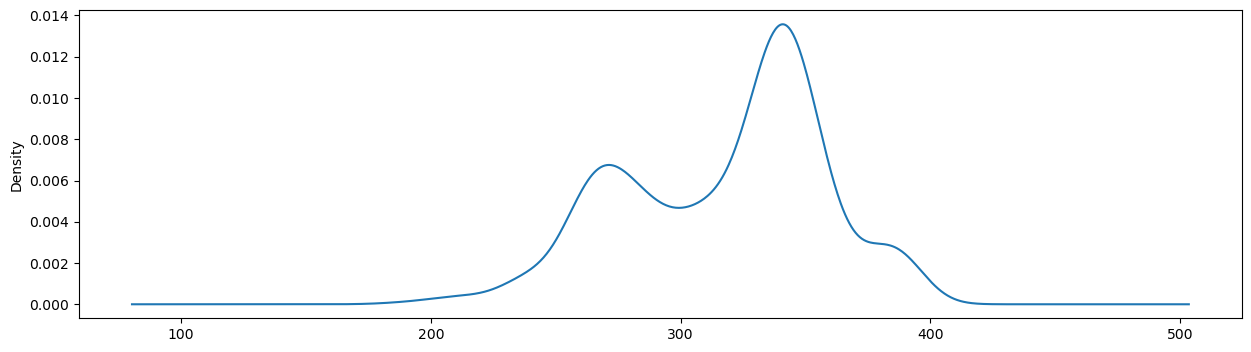

In [94]:
df_arima2['Price'].plot(kind = 'kde', figsize = (15,4))

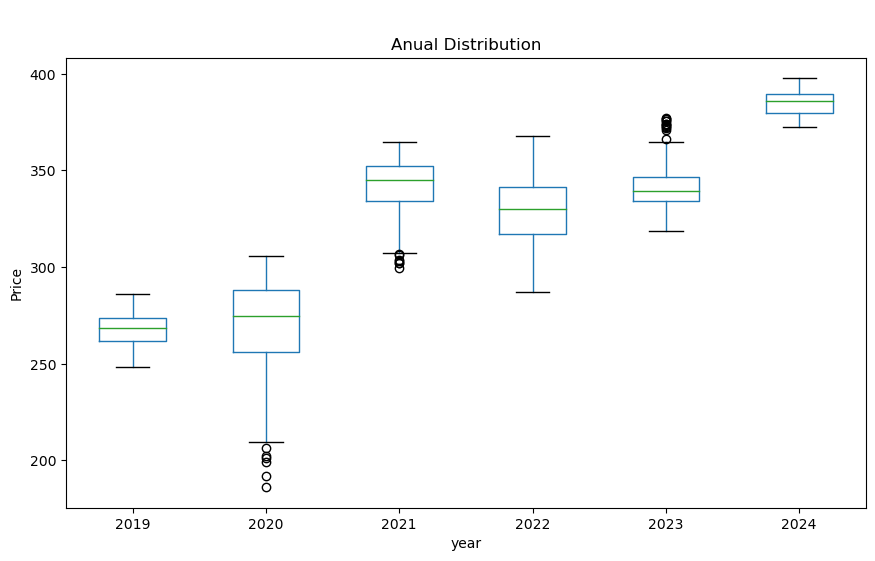

In [95]:
datos = df_arima2.copy()
fig, ax = plt.subplots(figsize = (10,6))
datos['year'] = datos.index.year
datos.boxplot(column = 'Price', by = 'year', ax=ax, grid = False)
ax.set_ylabel('Price')
ax.set_title('Anual Distribution')
fig.suptitle(' ');
plt.show()

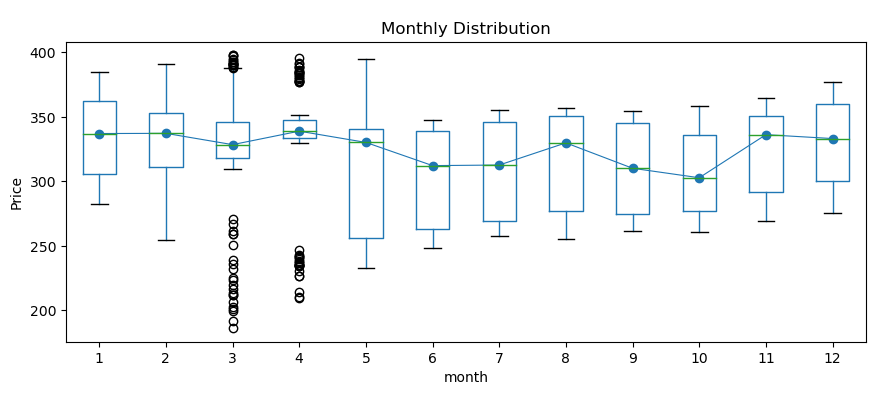

In [96]:
datos = df_arima2.copy()
fig, ax = plt.subplots(figsize = (10,4))
datos['month'] = datos.index.month
datos.boxplot(column = 'Price', by = 'month', ax=ax,)
datos.groupby('month')['Price'].median().plot(style = 'o-', linewidth = 0.8, ax=ax)
ax.set_ylabel('Price')
ax.set_title('Monthly Distribution')
fig.suptitle(' ');

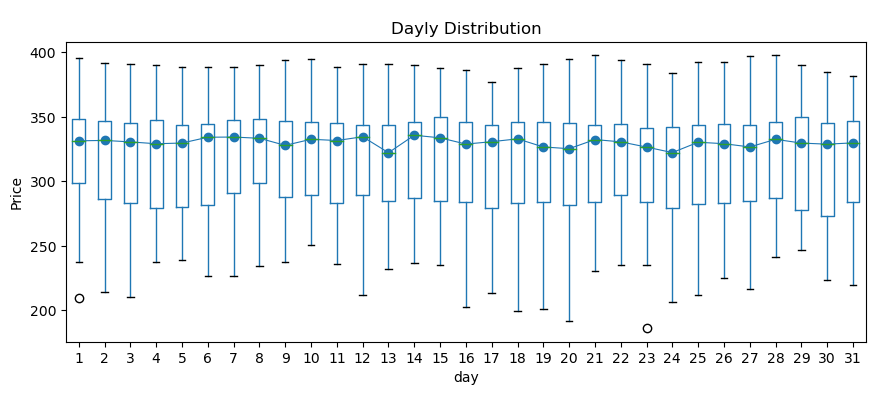

In [97]:
datos = df_arima2.copy()
fig, ax = plt.subplots(figsize = (10,4))
datos['day'] = datos.index.day
datos.boxplot(column = 'Price', by = 'day', ax=ax)
datos.groupby('day')['Price'].median().plot(style = 'o-', linewidth = 0.8, ax=ax)
ax.set_ylabel('Price')
ax.set_title('Dayly Distribution')
fig.suptitle(' ');

In [98]:
# se puede ver que no es una sería estacionaria gráficamente
# vamos a plciar la prueba de dickey-fuller para comprobarlo analiticamente

In [99]:
# definimos una función para aplicar la prueba de Dickey - Fuller
def dickey_fuller_test(serie, target_column):
    print(f'Resultados de la prueba: {target_column}')
    dftest = adfuller(serie, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'No Lags Used', 'Número de observaciones'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dftest[1] <=0.05:
        print('Conclusión: Rechazar hipotesis nula. Los datos son estaiconario')
    else:
        print('Conclusión: No se puede rechazar la hitpotesis nular. Los datos no son estacionarios')
    return


In [100]:
dickey_fuller_test(df_arima2,'Price')

Resultados de la prueba: Price
Test Statistic               -1.415125
p-value                       0.575004
No Lags Used                  9.000000
Número de observaciones    1249.000000
Critical Value (1%)          -3.435596
Critical Value (5%)          -2.863857
Critical Value (10%)         -2.568004
dtype: float64
Conclusión: No se puede rechazar la hitpotesis nular. Los datos no son estacionarios


In [101]:
# aplicamos la differencia para seasonalizar la serie

df_arima_diff = df_arima2.copy()

df_arima_diff['Price_diff'] = df_arima2['Price'].diff()

df_arima_diff.dropna(inplace = True)

df_arima_diff.head(3)

,Price,Price_diff
Date,,
2019-05-14,255.81,2.34
2019-05-15,256.92,1.11
2019-05-16,259.16,2.24


In [102]:
# aplico la prueba de dickey-fuller denuvo con los datos diferenciados
dickey_fuller_test(df_arima_diff['Price_diff'], 'Price_diff')

Resultados de la prueba: Price_diff
Test Statistic            -1.069396e+01
p-value                    3.665176e-19
No Lags Used               8.000000e+00
Número de observaciones    1.249000e+03
Critical Value (1%)       -3.435596e+00
Critical Value (5%)       -2.863857e+00
Critical Value (10%)      -2.568004e+00
dtype: float64
Conclusión: Rechazar hipotesis nula. Los datos son estaiconario


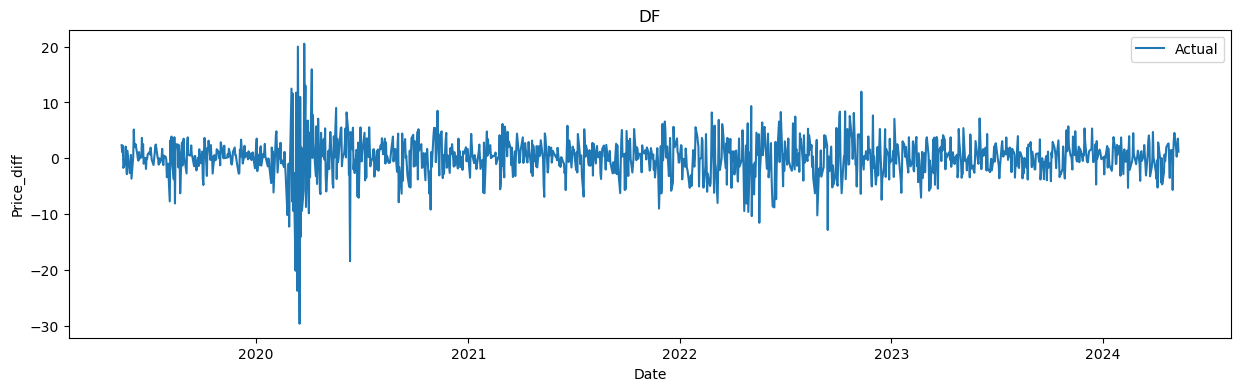

In [103]:
#graficamos la nueva serie con las diferencias 
plt.figure(figsize=(15, 4))
plt.plot(df_arima_diff.index, df_arima_diff['Price_diff'], label='Actual')
plt.xlabel('Date')
plt.ylabel('Price_diff')
plt.title('DF')
plt.legend()
plt.show()

<Figure size 1600x1000 with 0 Axes>

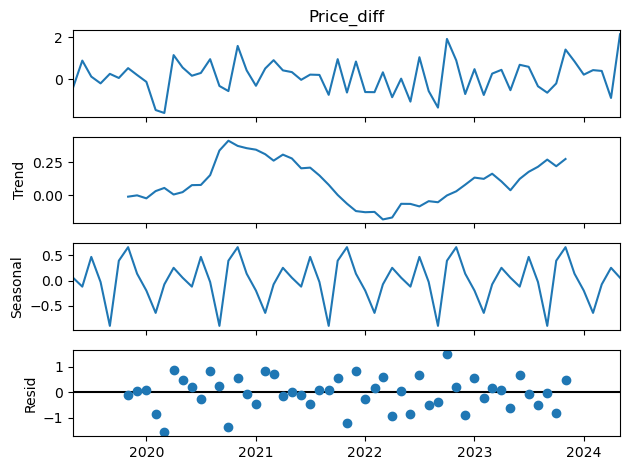

In [104]:
# descompongo en la sesionalidad

y = df_arima_diff['Price_diff'].resample('MS').mean()
plt.figure(figsize=(16,10))
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot()
plt.show()

In [105]:
# separamos en train y test
arima_train, arima_test = train_test_split(df_arima_diff, test_size=300, random_state=2024, shuffle=False)

print(arima_train.shape)
print(arima_test.shape)

(958, 2)
(300, 2)


In [106]:
# ejecutamos auto_arima para obtener los mejores parametros usamos m=5 porque el fondo opera los 5 días habiles nomas, no hay registros los fines de semana
modelo_auto = auto_arima(arima_train['Price_diff'], start_p=0,d=1,start_q=0,
                        max_p=4,max_d=2,max_q=4,start_P=0,
                        D=1, start_Q=0, max_P=2,max_D=1,
                        max_Q=2,m=5,seasonal=True,
                        error_action='warn', trace=True,
                        supress_warnings=True, stepwise=True,
                        random_state=2024, n_fits=50)
print(modelo_auto)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=6573.769, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=6027.476, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=0.31 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=6238.981, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=5929.056, Time=0.14 sec
 ARIMA(1,1,0)(2,1,1)[5]             : AIC=inf, Time=1.01 sec
 ARIMA(1,1,0)(1,1,1)[5]             : AIC=inf, Time=0.50 sec
 ARIMA(0,1,0)(2,1,0)[5]             : AIC=6371.216, Time=0.08 sec
 ARIMA(2,1,0)(2,1,0)[5]             : AIC=5834.249, Time=0.17 sec
 ARIMA(2,1,0)(1,1,0)[5]             : AIC=5941.246, Time=0.09 sec
 ARIMA(2,1,0)(2,1,1)[5]             : AIC=inf, Time=1.06 sec
 ARIMA(2,1,0)(1,1,1)[5]             : AIC=inf, Time=0.67 sec
 ARIMA(3,1,0)(2,1,0)[5]             : AIC=5804.936, Time=0.22 sec
 ARIMA(3,1,0)(1,1,0)[5]             : AIC=5905.646, Time=0.12 sec
 ARIMA(3,1,0)(2,1,1)[5]             : AIC=inf, Time=1.49 s

In [107]:
print(modelo_auto.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  958
Model:             SARIMAX(4, 1, 0)x(2, 1, 0, 5)   Log Likelihood               -2865.720
Date:                           Sun, 19 May 2024   AIC                           5745.440
Time:                                   19:46:36   BIC                           5779.450
Sample:                                        0   HQIC                          5758.397
                                           - 958                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9815      0.021    -47.596      0.000      -1.022      -0.941
ar.L2         -0.6197      0.031    -20.182

In [108]:
# implementamos el modelo

arima_model = SARIMAX (arima_train['Price_diff'], order = (4,1,0), season_order = (2,1,0,5)).fit()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['season_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


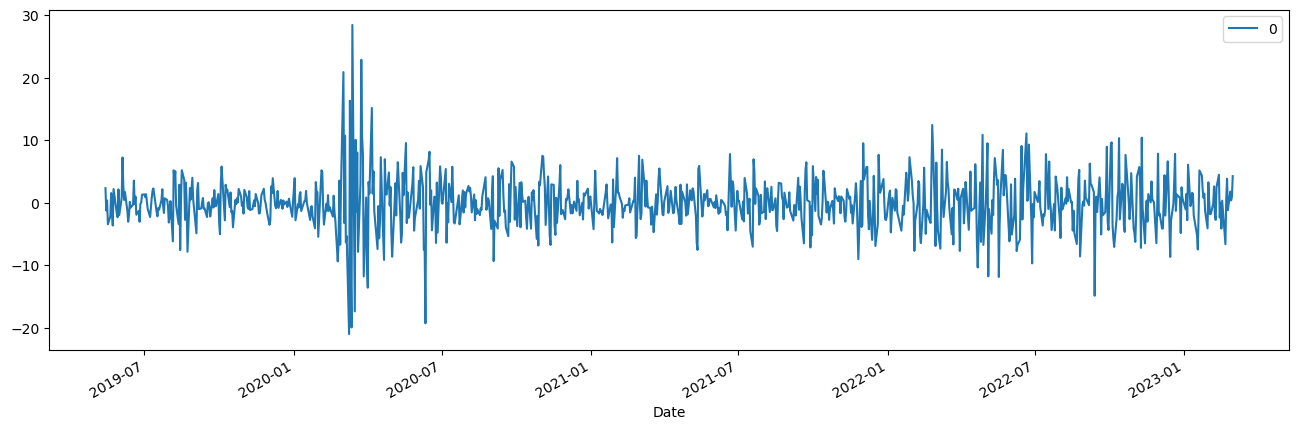

In [109]:
# graficamos los errores residuales del modelo

residuals = pd.DataFrame(arima_model.resid)
residuals.plot(figsize = (16,5));
plt.show()

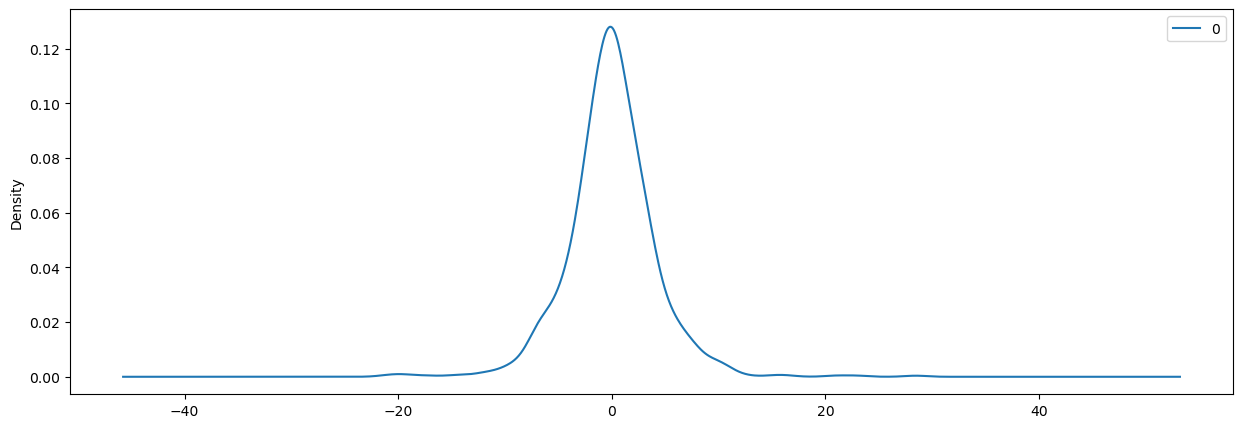

                0
count  958.000000
mean    -0.002477
std      4.151411
min    -21.015200
25%     -2.040474
50%      0.023281
75%      2.067265
max     28.460123


In [110]:
# graficamos la densidad los errores residuales del modelo

residuals.plot(kind='kde', figsize=(15,5))
plt.show()
print(residuals.describe())